# Train DL Methods
- Environment setup
- Load CIC-IDS2017 original as upstream data
- Train-Test split
- Normalise data
- Train model by autoencoders
- Train model by Deep Neural Network

### Environment setup

In [ ]:
from __future__ import print_function
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!wget https://downloads.rclone.org/v1.63.0/rclone-v1.63.0-linux-amd64.deb
!apt install ./rclone-v1.63.0-linux-amd64.deb
!rclone config
!sudo apt-get -y install fuse3

--2023-08-06 15:18:25--  https://downloads.rclone.org/v1.63.0/rclone-v1.63.0-linux-amd64.deb
Resolving downloads.rclone.org (downloads.rclone.org)... 95.217.6.16, 2a01:4f9:c012:7154::1
Connecting to downloads.rclone.org (downloads.rclone.org)|95.217.6.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18373062 (18M) [application/vnd.debian.binary-package]
Saving to: ‘rclone-v1.63.0-linux-amd64.deb’

rclone-v1.63.0-linu 100%[===================>]  17.52M  11.9MB/s    in 1.5s    

2023-08-06 15:18:27 (11.9 MB/s) - ‘rclone-v1.63.0-linux-amd64.deb’ saved [18373062/18373062]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'rclone' instead of './rclone-v1.63.0-linux-amd64.deb'
The following NEW packages will be installed:
  rclone
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 0 B/18.4 MB of archives.
After this operation, 56.7 MB of additional disk space will be used.
Get

In [ ]:
!sudo mkdir /content/onedrive
!nohup rclone --vfs-cache-mode writes mount onedrive: /content/onedrive &

nohup: appending output to 'nohup.out'


### Load CIC-IDS2017 original as upstream data

In [ ]:
# Import Necessary Libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt # plotting
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score

# for Deep Learning
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

import time
import os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.0/966.0 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.2.7
    Uninstalling hyperopt-0.2.7:
      Successfully uninstalled hyperopt-0.2.7


In [ ]:
# data2017_original = pd.read_parquet('/content/onedrive/data_2017_original.parquet', engine="fastparquet")
# data2017_corrected = pd.read_parquet('/content/onedrive/data_2017_corrected.parquet', engine="fastparquet")
# data2018_original = pd.read_parquet('/content/onedrive/data_2018_original.parquet', engine="fastparquet")
data2018_corrected = pd.read_parquet('/content/onedrive//data_2018_corrected_sampling.parquet', engine="fastparquet")

In [ ]:
data2017_original_resampling = pd.read_parquet('/content/onedrive/data_2017_original_resampling.parquet', engine="fastparquet")
# data2017_corrected_resampling = pd.read_parquet('/content/onedrive/data_2017_corrected_resampling.parquet', engine="fastparquet")
# data2018_original_resampling = pd.read_parquet('/content/onedrive/data_2018_original_resampling.parquet', engine="fastparquet")
# data2018_corrected_resampling = pd.read_parquet('/content/onedrive/data_2018_corrected_sampling_resampling.parquet', engine="fastparquet")

### Train-Test Split

In [ ]:
data2017_original['label_encoded'].value_counts()

0    2095057
1     425741
Name: label_encoded, dtype: int64

In [ ]:
data2017_corrected['label_encoded'].value_counts()

0    1582561
1     517410
Name: label_encoded, dtype: int64

In [ ]:
data2018_original['label_encoded'].value_counts()


0    9493199
1    1325845
Name: label_encoded, dtype: int64

In [ ]:
data2018_corrected['label_encoded'].value_counts()

0    5935341
1    3841659
Name: label_encoded, dtype: int64

In [ ]:
def split_data(data):
    X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'label_encoded'], data['label_encoded'], test_size=0.2, random_state=42) #reproducible

    num_rows, num_cols = X_train.shape
    print(f"Number of rows of train data: {num_rows}")
    print(f"Number of columns of train data: {num_cols}")

    num_rows, num_cols = X_test.shape
    print(f"Number of rows of test data: {num_rows}")
    print(f"Number of columns of test data: {num_cols}")

    print("------------------------------------------")
    print(f"train - benign: {y_train[y_train == 0].shape[0]}; attack: {y_train[y_train == 1].shape[0]}")
    print(f"test - benign: {y_test[y_test == 0].shape[0]}; attack: {y_test[y_test == 1].shape[0]}")

    return X_train, X_test, y_train, y_test

In [ ]:
def normalise_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test

In [ ]:
X_train, X_test, y_train, y_test = split_data(data2017_original)

data_test_2017_original = pd.concat([X_test, y_test], axis=1)
X_train, X_test = normalise_data(X_train, X_test)

Number of rows of train data: 2016638
Number of columns of train data: 76
Number of rows of test data: 504160
Number of columns of test data: 76
------------------------------------------
train - benign: 1676159; attack: 340479
test - benign: 418898; attack: 85262


In [ ]:
del data2017_original

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = split_data(data2017_original_resampling)

data_test_2017_original_r = pd.concat([X_test_r, y_test_r], axis=1)
X_train_r, X_test_r = normalise_data(X_train_r, X_test_r)

Number of rows of train data: 681185
Number of columns of train data: 76
Number of rows of test data: 170297
Number of columns of test data: 76
------------------------------------------
train - benign: 340605; attack: 340580
test - benign: 85136; attack: 85161


In [ ]:
del data2017_original_resampling

In [ ]:
X_train, X_test, y_train, y_test = split_data(data2017_corrected)

data_test_2017_corrected = pd.concat([X_test, y_test], axis=1)
X_train, X_test = normalise_data(X_train, X_test)

Number of rows of train data: 1679976
Number of columns of train data: 82
Number of rows of test data: 419995
Number of columns of test data: 82
------------------------------------------
train - benign: 1275371; attack: 404605
test - benign: 319169; attack: 100826


In [ ]:
del data2017_corrected

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = split_data(data2017_corrected_resampling)

data_test_2017_corrected_r = pd.concat([X_test_r, y_test_r], axis=1)
X_train_r, X_test_r = normalise_data(X_train_r, X_test_r)

Number of rows of train data: 808689
Number of columns of train data: 82
Number of rows of test data: 202173
Number of columns of test data: 82
------------------------------------------
train - benign: 404134; attack: 404555
test - benign: 101297; attack: 100876


In [ ]:
del data2017_corrected_resampling

In [ ]:
X_train, X_test, y_train, y_test = split_data(data2018_original)

data_test_2018_original = pd.concat([X_test, y_test], axis=1)
X_train, X_test = normalise_data(X_train, X_test)

Number of rows of train data: 8655235
Number of columns of train data: 76
Number of rows of test data: 2163809
Number of columns of test data: 76
------------------------------------------
train - benign: 7594777; attack: 1060458
test - benign: 1898422; attack: 265387


In [ ]:
del data2018_original

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = split_data(data2018_original_resampling)

data_test_2018_original_r = pd.concat([X_test_r, y_test_r], axis=1)
X_train_r, X_test_r = normalise_data(X_train_r, X_test_r)

Number of rows of train data: 2121352
Number of columns of train data: 76
Number of rows of test data: 530338
Number of columns of test data: 76
------------------------------------------
train - benign: 1060746; attack: 1060606
test - benign: 265099; attack: 265239


In [ ]:
del data2018_original_resampling

In [ ]:
X_train, X_test, y_train, y_test = split_data(data2018_corrected)

data_test_2018_corrected = pd.concat([X_test, y_test], axis=1)
X_train, X_test = normalise_data(X_train, X_test)

Number of rows of train data: 7821600
Number of columns of train data: 81
Number of rows of test data: 1955400
Number of columns of test data: 81
------------------------------------------
train - benign: 4748687; attack: 3072913
test - benign: 1186654; attack: 768746


In [ ]:
del data2018_corrected

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = split_data(data2018_corrected_resampling)

data_test_2018_corrected_r = pd.concat([X_test_r, y_test_r], axis=1)
X_train_r, X_test_r = normalise_data(X_train_r, X_test_r)

Number of rows of train data: 6146650
Number of columns of train data: 81
Number of rows of test data: 1536663
Number of columns of test data: 81
------------------------------------------
train - benign: 3072997; attack: 3073653
test - benign: 768657; attack: 768006


In [ ]:
del data2018_corrected_resampling

### Train model by Autoencoders

In [ ]:
def data():
  data2017_original = pd.read_parquet('/content/onedrive/data_2017_original.parquet', engine="fastparquet")
  X_train, X_test, y_train, y_test = split_data(data2017_original)
  X_train, X_test = normalise_data(X_train, X_test)
  return X_train, y_train, X_test, y_test

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def model(X_train, Y_train, X_test, Y_test):
  '''
  Model providing function:
  Create Keras model with double curly brackets dropped-in as needed.
  Return value has to be a valid python dictionary with two customary keys:
      - loss: Specify a numeric evaluation metric to be minimized
      - status: Just use STATUS_OK and see hyperopt documentation if not feasible
  The last one is optional, though recommended, namely:
      - model: specify the model just created so that we can later use it again.
  '''


  input_shape = tf.keras.layers.Input(shape=(76,))
  encoded = tf.keras.layers.Dense(64, activation="relu")(input_shape)
  encoded_1 = tf.keras.layers.Dense(32, activation="relu")(encoded)
  encoded_2 = tf.keras.layers.Dense(16, activation="relu")(encoded_1)

  decoded = tf.keras.layers.Dense(32, activation="relu")(encoded_2)
  decoded_1 = tf.keras.layers.Dense(64, activation="relu")(decoded)
  decoded_2 = tf.keras.layers.Dense(76, activation="sigmoid")(decoded_1)

  output = tf.keras.layers.Dense(1, activation='sigmoid')(decoded_2)

  model = Model(input_shape, output)

  model.compile(loss='binary_crossentropy',
                optimizer={{choice(['rmsprop', 'adam', 'sgd'])}},
                metrics=['accuracy', f1_m, precision_m, recall_m])

  checkpoint_path = "/content/onedrive/models/autoencoder_classifier_resampling.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      verbose=1)
  start_time = time.time()

  model.fit(X_train, y_train,
            batch_size={{choice([32, 64, 128])}},
            epochs=1,
            verbose=1,
            validation_split=0.1,
            callbacks=cp_callback)

  end_time = time.time()
  time_taken = end_time - start_time
  print("Time taken to fit the model:", time_taken, "seconds")

  score, acc, f1, precision, recall = model.evaluate(X_test, y_test, verbose=0)
  print(f'Test accuracy: {acc}, f1: {f1}, precision: {precision}, recall: {recall}')
  return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run, best_model = optim.minimize(model = model,
                                      data = data,
                                      max_evals = 10,
                                      algo = tpe.suggest,
                                      notebook_name = "gdrive/MyDrive/diss/train_deep_learning_methods",
                                      trials = Trials(),
                                      functions = [f1_m,precision_m, recall_m, split_data, normalise_data])

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    from google.colab import drive
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
except:
    pass

try:
    from sklearn.impute import SimpleImputer
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn.manifold import TSNE
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, precision_recall_curve
except:
    pass

try:
    from sklearn.metrics import recall_score, classification_report, auc, roc_curve
except:
    pass

try:
    from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
   

Cause: Unable to locate the source code of <function f1_m at 0x7890f2dd4310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function f1_m at 0x7890f2dd4310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
  0%|          | 0/10 [00:06<?, ?trial/s, best loss=?]

Cause: Unable to locate the source code of <function precision_m at 0x7890f2dd4280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function precision_m at 0x7890f2dd4280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
  0%|          | 0/10 [00:06<?, ?trial/s, best loss=?]

Cause: Unable to locate the source code of <function recall_m at 0x7890f2dd41f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Streaming output truncated to the last 5000 lines.
56715/56718 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.9781 - f1_m: 0.9235 - precision_m: 0.9504 - recall_m: 0.9126

Epoch 1: saving model to /content/onedrive/models/autoencoder_classifier_resampling.ckpt

56718/56718 [==============================] - 325s 6ms/step - loss: 0.0519 - accuracy: 0.9781 - f1_m: 0.9235 - precision_m: 0.9504 - recall_m: 0.9126 - val_loss: 0.0453 - val_accuracy: 0.9809 - val_f1_m: 0.9335 - val_precision_m: 0.9417 - val_recall_m: 0.9384

Time taken to fit the model:
384.7895004749298
seconds
Test accuracy: 0.9813709855079651, f1: 0.9363581538200378, precision: 0.9435554146766663, recall: 0.9415346384048462
100%|██████████| 10/10 [34:31<00:00, 207.11s/trial, best loss: -0.9814225435256958]


In [ ]:
best_run

{'batch_size': 2, 'optimizer': 0}

### Autoencoder

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
epochs = 16
batch_size = 128
input_dim = X_train.shape[1] #num of feature columns

class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
              ])
        self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(input_dim, activation="sigmoid")
              ])
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        label_pred = self.output_layer(decoded)
        return label_pred

In [ ]:
def train_autoencoder(X, y):
  autoencoder = AutoEncoder()
  autoencoder.compile(loss='mae',
                      optimizer='rmsprop',
                      metrics=['acc',f1_m, precision_m, recall_m])

  checkpoint_path = "/content/onedrive/models/autoencoder_classifier_resampling.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                   save_weights_only=True,
                                                   verbose=1)
  start_time = time.time()
  history_ae = autoencoder.fit(X, y,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_split=0.1,
                      verbose=1)
                      # callbacks=cp_callback)
  end_time = time.time()
  time_taken = end_time - start_time
  print("Time taken to fit the model:", time_taken, "seconds")
  return autoencoder, history_ae

In [ ]:
def evaluate_ae(df, X, y):
  ypred = autoencoder.predict(X)
  # Define a threshold for converting predictions to binary class labels
  threshold = 0.5

  # Convert predictions to binary class labels
  predicted_classes = (ypred >= threshold).astype(int)
  df['ypreds_ae'] = predicted_classes
  print(classification_report(y, predicted_classes))
  autoencoder.evaluate(X, y, verbose=2)

### 2017 original

In [ ]:
autoencoder, history_ae = train_autoencoder(X_train, y_train)

Epoch 1/16
14169/14180 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9410 - f1_m: 0.7872 - precision_m: 0.9819 - recall_m: 0.6653
Epoch 1: saving model to /content/onedrive/models/autoencoder_classifier.ckpt
14180/14180 [==============================] - 45s 3ms/step - loss: 0.0591 - acc: 0.9410 - f1_m: 0.7872 - precision_m: 0.9819 - recall_m: 0.6653 - val_loss: 0.0547 - val_acc: 0.9453 - val_f1_m: 0.8026 - val_precision_m: 0.9950 - val_recall_m: 0.6788
Epoch 2/16
14180/14180 [==============================] - ETA: 0s - loss: 0.0572 - acc: 0.9428 - f1_m: 0.7945 - precision_m: 0.9832 - recall_m: 0.6740
Epoch 2: saving model to /content/onedrive/models/autoencoder_classifier.ckpt
14180/14180 [==============================] - 37s 3ms/step - loss: 0.0572 - acc: 0.9428 - f1_m: 0.7945 - precision_m: 0.9832 - recall_m: 0.6740 - val_loss: 0.0549 - val_acc: 0.9451 - val_f1_m: 0.8013 - val_precision_m: 0.9989 - val_recall_m: 0.6753
Epoch 3/16
14168/14180 [==================

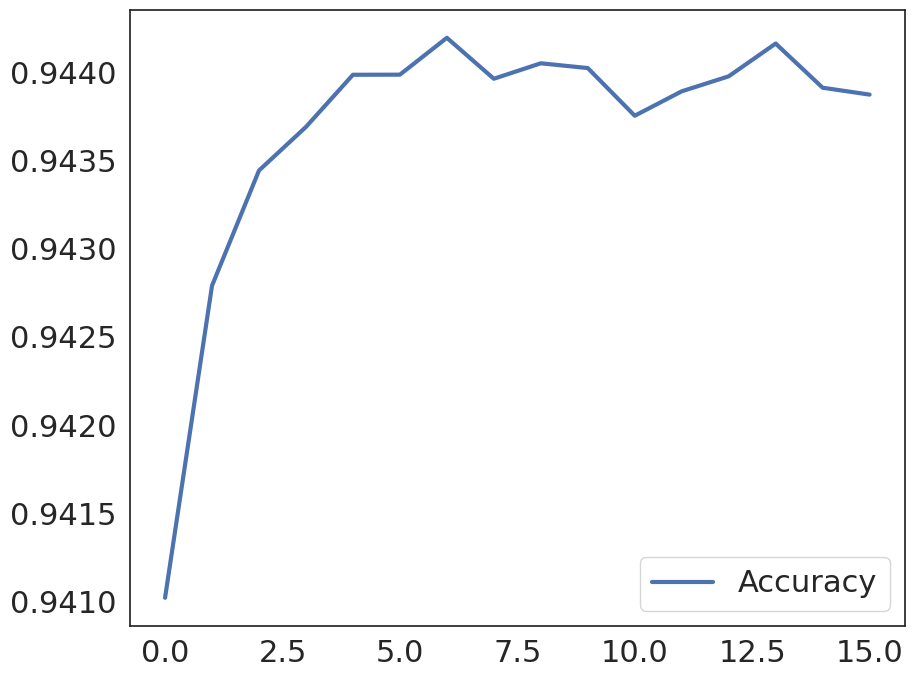

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_ae.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_ae(data_test_2017_original, X_test, y_test)

15755/15755 [==============================] - 19s 1ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    418898
           1       0.99      0.68      0.81     85262

    accuracy                           0.95    504160
   macro avg       0.97      0.84      0.89    504160
weighted avg       0.95      0.95      0.94    504160

15755/15755 - 21s - loss: 0.0544 - acc: 0.9456 - f1_m: 0.7833 - precision_m: 0.9728 - recall_m: 0.6812 - 21s/epoch - 1ms/step


### Resampling

In [ ]:
autoencoder, history_ae = train_autoencoder(X_train_r, y_train_r)

Epoch 1/16
4788/4790 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9502 - f1_m: 0.9499 - precision_m: 0.9553 - recall_m: 0.9465
Epoch 1: saving model to /content/onedrive/models/autoencoder_classifier_resampling.ckpt
4790/4790 [==============================] - 22s 4ms/step - loss: 0.0508 - acc: 0.9502 - f1_m: 0.9499 - precision_m: 0.9553 - recall_m: 0.9465 - val_loss: 0.0431 - val_acc: 0.9569 - val_f1_m: 0.9556 - val_precision_m: 0.9735 - val_recall_m: 0.9390
Epoch 2/16
4778/4790 [============================>.] - ETA: 0s - loss: 0.0463 - acc: 0.9537 - f1_m: 0.9531 - precision_m: 0.9604 - recall_m: 0.9471
Epoch 2: saving model to /content/onedrive/models/autoencoder_classifier_resampling.ckpt
4790/4790 [==============================] - 18s 4ms/step - loss: 0.0463 - acc: 0.9537 - f1_m: 0.9531 - precision_m: 0.9604 - recall_m: 0.9470 - val_loss: 0.0425 - val_acc: 0.9575 - val_f1_m: 0.9562 - val_precision_m: 0.9752 - val_recall_m: 0.9386
Epoch 3/16
4783/4790 [======

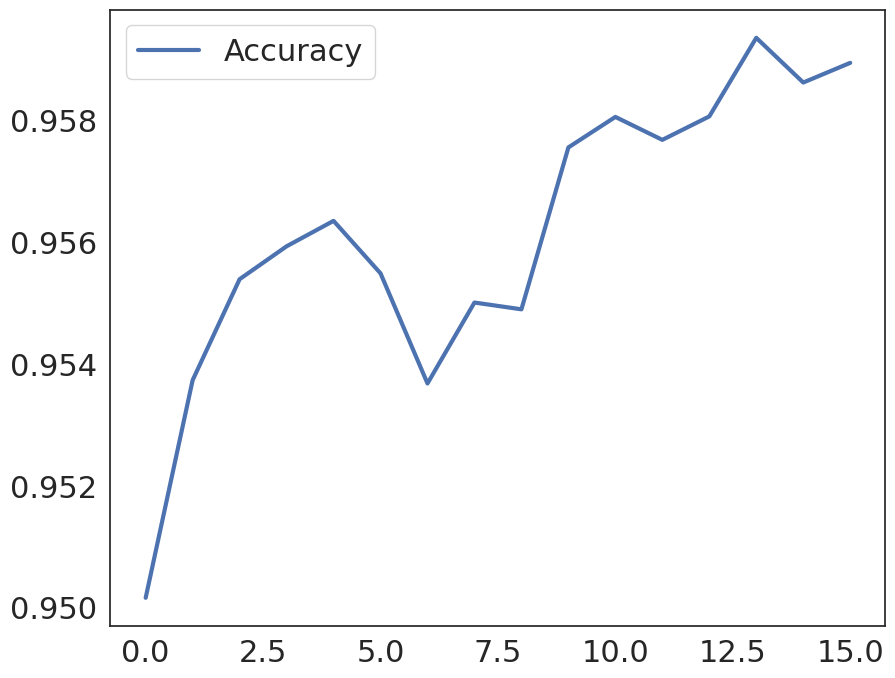

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_ae.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_ae(data_test_2017_original_r, X_test_r, y_test_r)

5322/5322 [==============================] - 8s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     85136
           1       0.95      0.96      0.95     85161

    accuracy                           0.95    170297
   macro avg       0.95      0.95      0.95    170297
weighted avg       0.95      0.95      0.95    170297

5322/5322 - 9s - loss: 0.0455 - acc: 0.9545 - f1_m: 0.9531 - precision_m: 0.9519 - recall_m: 0.9572 - 9s/epoch - 2ms/step


### Train 2017 corrected dataset

In [ ]:
autoencoder, history_ae = train_autoencoder(X_train, y_train)

Epoch 1/16
11813/11813 [==============================] - 62s 5ms/step - loss: 0.0083 - acc: 0.9918 - f1_m: 0.9827 - precision_m: 0.9913 - recall_m: 0.9751 - val_loss: 0.0052 - val_acc: 0.9948 - val_f1_m: 0.9890 - val_precision_m: 0.9984 - val_recall_m: 0.9801
Epoch 2/16
11813/11813 [==============================] - 38s 3ms/step - loss: 0.0053 - acc: 0.9947 - f1_m: 0.9887 - precision_m: 0.9977 - recall_m: 0.9802 - val_loss: 0.0049 - val_acc: 0.9951 - val_f1_m: 0.9898 - val_precision_m: 0.9977 - val_recall_m: 0.9823
Epoch 3/16
11813/11813 [==============================] - 41s 4ms/step - loss: 0.0050 - acc: 0.9950 - f1_m: 0.9894 - precision_m: 0.9988 - recall_m: 0.9806 - val_loss: 0.0044 - val_acc: 0.9956 - val_f1_m: 0.9907 - val_precision_m: 0.9995 - val_recall_m: 0.9822
Epoch 4/16
11813/11813 [==============================] - 40s 3ms/step - loss: 0.0048 - acc: 0.9952 - f1_m: 0.9897 - precision_m: 0.9992 - recall_m: 0.9807 - val_loss: 0.0047 - val_acc: 0.9953 - val_f1_m: 0.9901 - val

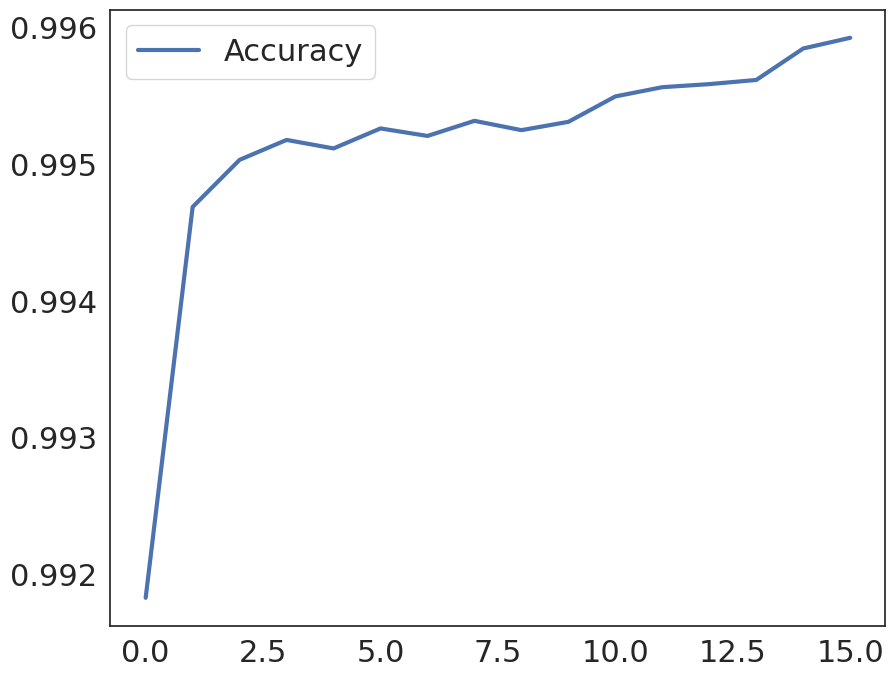

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_ae.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_ae(data_test_2017_corrected, X_test, y_test)

13125/13125 [==============================] - 20s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    319169
           1       1.00      0.98      0.99    100826

    accuracy                           1.00    419995
   macro avg       1.00      0.99      0.99    419995
weighted avg       1.00      1.00      1.00    419995

13125/13125 - 19s - loss: 0.0040 - acc: 0.9959 - f1_m: 0.9906 - precision_m: 0.9989 - recall_m: 0.9837 - 19s/epoch - 1ms/step


### Resampling

In [ ]:
autoencoder, history_ae = train_autoencoder(X_train_r, y_train_r)

Epoch 1/16
5687/5687 [==============================] - 22s 4ms/step - loss: 0.0114 - acc: 0.9893 - f1_m: 0.9880 - precision_m: 0.9932 - recall_m: 0.9832 - val_loss: 0.0083 - val_acc: 0.9918 - val_f1_m: 0.9916 - val_precision_m: 0.9964 - val_recall_m: 0.9871
Epoch 2/16
5687/5687 [==============================] - 18s 3ms/step - loss: 0.0087 - acc: 0.9913 - f1_m: 0.9912 - precision_m: 0.9962 - recall_m: 0.9864 - val_loss: 0.0080 - val_acc: 0.9920 - val_f1_m: 0.9919 - val_precision_m: 0.9963 - val_recall_m: 0.9877
Epoch 3/16
5687/5687 [==============================] - 18s 3ms/step - loss: 0.0085 - acc: 0.9915 - f1_m: 0.9914 - precision_m: 0.9962 - recall_m: 0.9868 - val_loss: 0.0080 - val_acc: 0.9920 - val_f1_m: 0.9919 - val_precision_m: 0.9965 - val_recall_m: 0.9874
Epoch 4/16
5687/5687 [==============================] - 19s 3ms/step - loss: 0.0085 - acc: 0.9915 - f1_m: 0.9914 - precision_m: 0.9962 - recall_m: 0.9868 - val_loss: 0.0081 - val_acc: 0.9919 - val_f1_m: 0.9918 - val_precisi

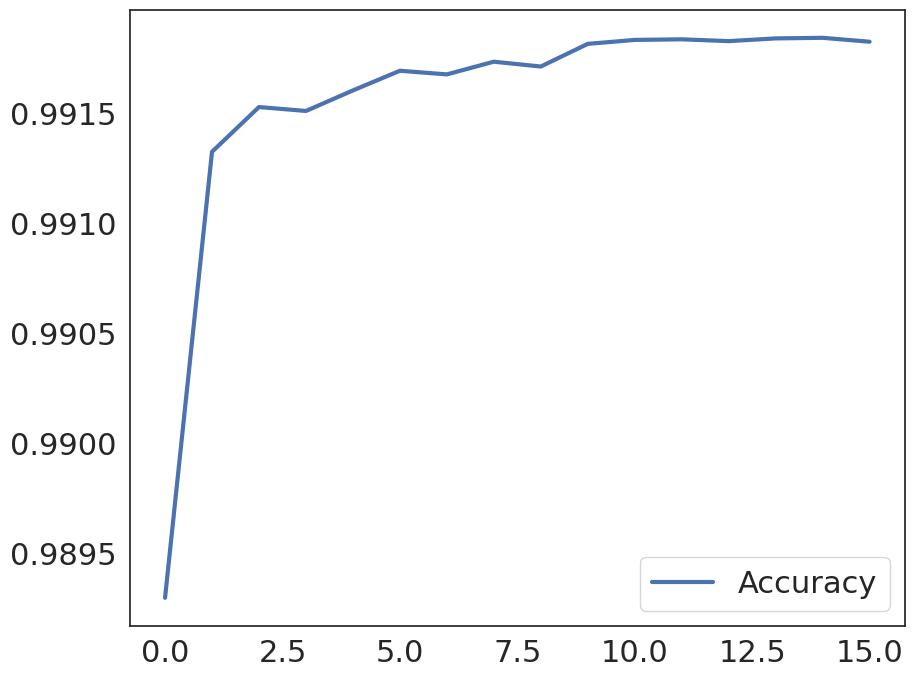

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_ae.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_ae(data_test_2017_corrected_r, X_test_r, y_test_r)

6318/6318 [==============================] - 8s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    101297
           1       1.00      0.99      0.99    100876

    accuracy                           0.99    202173
   macro avg       0.99      0.99      0.99    202173
weighted avg       0.99      0.99      0.99    202173

6318/6318 - 10s - loss: 0.0083 - acc: 0.9917 - f1_m: 0.9914 - precision_m: 0.9960 - recall_m: 0.9874 - 10s/epoch - 2ms/step


### Train on 2018 dataset

In [ ]:
autoencoder, history_ae = train_autoencoder(X_train, y_train)

Epoch 1/16
60858/60858 [==============================] - 161s 3ms/step - loss: 0.0555 - acc: 0.9446 - f1_m: 0.6984 - precision_m: 0.9957 - recall_m: 0.5489 - val_loss: 0.0548 - val_acc: 0.9452 - val_f1_m: 0.7022 - val_precision_m: 0.9998 - val_recall_m: 0.5522
Epoch 2/16
60858/60858 [==============================] - 160s 3ms/step - loss: 0.0550 - acc: 0.9450 - f1_m: 0.7016 - precision_m: 0.9998 - recall_m: 0.5513 - val_loss: 0.0548 - val_acc: 0.9452 - val_f1_m: 0.7022 - val_precision_m: 0.9998 - val_recall_m: 0.5523
Epoch 3/16
60858/60858 [==============================] - 160s 3ms/step - loss: 0.0550 - acc: 0.9450 - f1_m: 0.7016 - precision_m: 0.9997 - recall_m: 0.5514 - val_loss: 0.0548 - val_acc: 0.9452 - val_f1_m: 0.7022 - val_precision_m: 0.9999 - val_recall_m: 0.5522
Epoch 4/16
60858/60858 [==============================] - 166s 3ms/step - loss: 0.0550 - acc: 0.9450 - f1_m: 0.7015 - precision_m: 0.9997 - recall_m: 0.5511 - val_loss: 0.0548 - val_acc: 0.9452 - val_f1_m: 0.7023 -

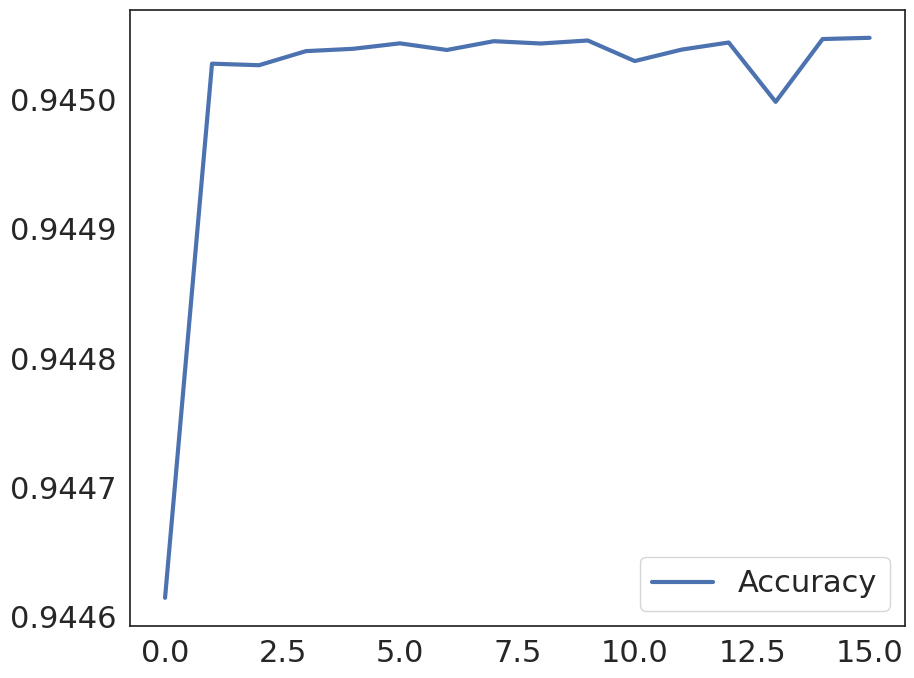

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_ae.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_ae(data_test_2018_original, X_test, y_test)

67620/67620 [==============================] - 85s 1ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1898422
           1       1.00      0.55      0.71    265387

    accuracy                           0.95   2163809
   macro avg       0.97      0.78      0.84   2163809
weighted avg       0.95      0.95      0.94   2163809

67620/67620 - 82s - loss: 0.0549 - acc: 0.9451 - f1_m: 0.6513 - precision_m: 0.8928 - recall_m: 0.5428 - 82s/epoch - 1ms/step


### Resampling

In [ ]:
autoencoder, history_ae = train_autoencoder(X_train_r, y_train_r)

Epoch 1/16
14916/14916 [==============================] - 41s 3ms/step - loss: 0.0710 - acc: 0.9294 - f1_m: 0.9263 - precision_m: 0.9634 - recall_m: 0.8934 - val_loss: 0.0682 - val_acc: 0.9318 - val_f1_m: 0.9283 - val_precision_m: 0.9706 - val_recall_m: 0.8905
Epoch 2/16
14916/14916 [==============================] - 36s 2ms/step - loss: 0.0683 - acc: 0.9317 - f1_m: 0.9285 - precision_m: 0.9663 - recall_m: 0.8947 - val_loss: 0.0683 - val_acc: 0.9317 - val_f1_m: 0.9282 - val_precision_m: 0.9719 - val_recall_m: 0.8891
Epoch 3/16
14916/14916 [==============================] - 37s 2ms/step - loss: 0.0678 - acc: 0.9322 - f1_m: 0.9289 - precision_m: 0.9674 - recall_m: 0.8944 - val_loss: 0.0709 - val_acc: 0.9291 - val_f1_m: 0.9263 - val_precision_m: 0.9588 - val_recall_m: 0.8970
Epoch 4/16
14916/14916 [==============================] - 36s 2ms/step - loss: 0.0762 - acc: 0.9238 - f1_m: 0.9192 - precision_m: 0.9680 - recall_m: 0.8765 - val_loss: 0.0818 - val_acc: 0.9182 - val_f1_m: 0.9126 - val

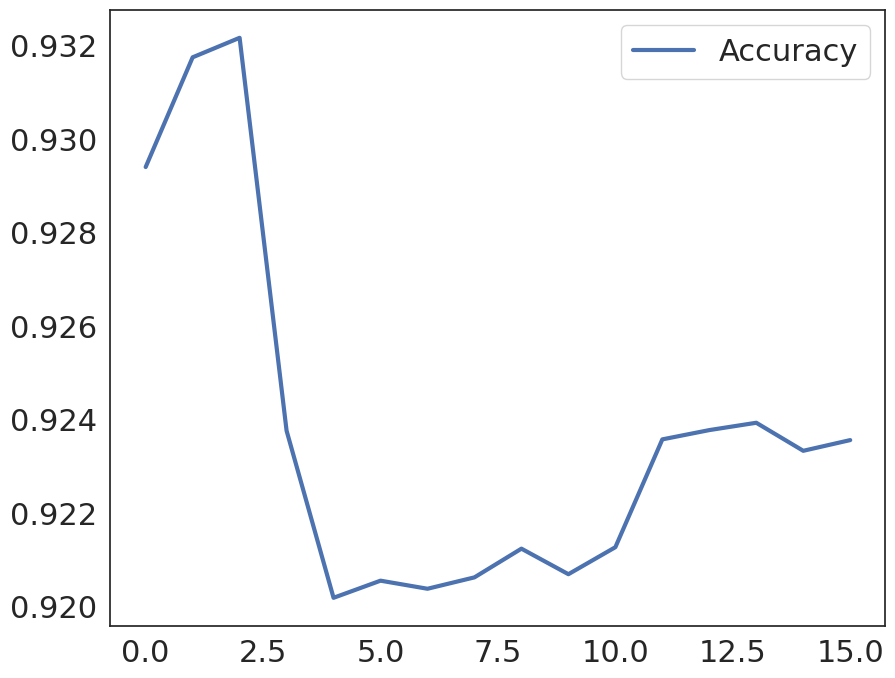

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_ae.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_ae(data_test_2018_original_r, X_test_r, y_test_r)

16574/16574 [==============================] - 20s 1ms/step
              precision    recall  f1-score   support

           0       0.89      0.98      0.93    265099
           1       0.97      0.87      0.92    265239

    accuracy                           0.92    530338
   macro avg       0.93      0.92      0.92    530338
weighted avg       0.93      0.92      0.92    530338

16574/16574 - 20s - loss: 0.0756 - acc: 0.9244 - f1_m: 0.9178 - precision_m: 0.9721 - recall_m: 0.8738 - 20s/epoch - 1ms/step


### 2018 improved

In [ ]:
autoencoder, history_ae = train_autoencoder(X_train, y_train)

Epoch 1/16
54996/54996 [==============================] - 226s 4ms/step - loss: 0.0073 - acc: 0.9928 - f1_m: 0.9907 - precision_m: 0.9993 - recall_m: 0.9824 - val_loss: 0.0068 - val_acc: 0.9932 - val_f1_m: 0.9912 - val_precision_m: 0.9998 - val_recall_m: 0.9829
Epoch 2/16
54996/54996 [==============================] - 173s 3ms/step - loss: 0.0069 - acc: 0.9931 - f1_m: 0.9910 - precision_m: 0.9997 - recall_m: 0.9827 - val_loss: 0.0067 - val_acc: 0.9933 - val_f1_m: 0.9913 - val_precision_m: 0.9998 - val_recall_m: 0.9831
Epoch 3/16
54996/54996 [==============================] - 151s 3ms/step - loss: 0.0067 - acc: 0.9933 - f1_m: 0.9913 - precision_m: 0.9997 - recall_m: 0.9832 - val_loss: 0.0067 - val_acc: 0.9933 - val_f1_m: 0.9913 - val_precision_m: 0.9998 - val_recall_m: 0.9831
Epoch 4/16
54996/54996 [==============================] - 165s 3ms/step - loss: 0.0063 - acc: 0.9937 - f1_m: 0.9918 - precision_m: 0.9997 - recall_m: 0.9842 - val_loss: 0.0062 - val_acc: 0.9938 - val_f1_m: 0.9919 -

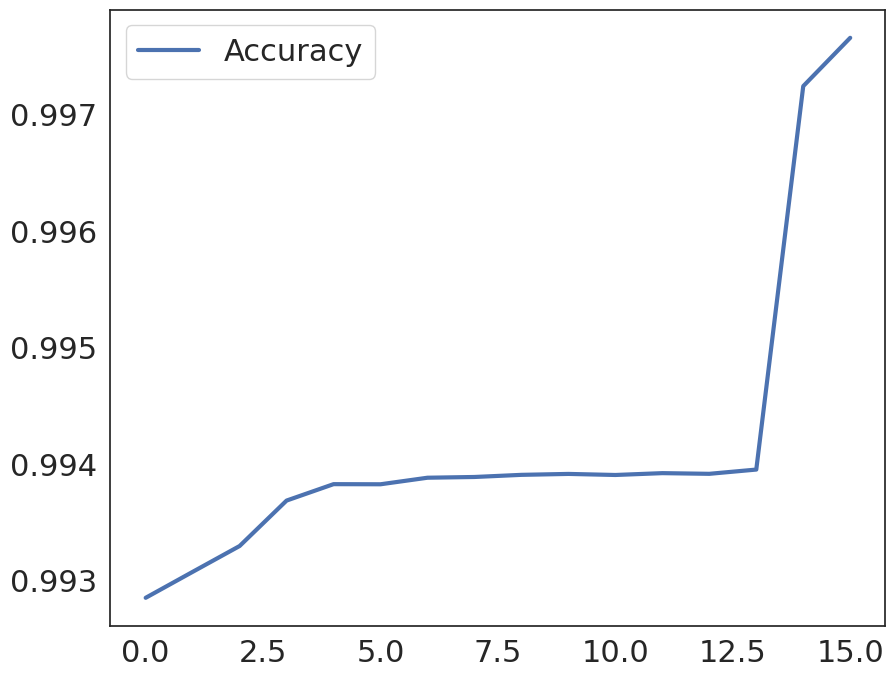

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_ae.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_ae(data_test_2018_corrected, X_test, y_test)

61107/61107 [==============================] - 76s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1186654
           1       1.00      0.99      1.00    768746

    accuracy                           1.00   1955400
   macro avg       1.00      1.00      1.00   1955400
weighted avg       1.00      1.00      1.00   1955400

61107/61107 - 77s - loss: 0.0021 - acc: 0.9979 - f1_m: 0.9972 - precision_m: 0.9999 - recall_m: 0.9947 - 77s/epoch - 1ms/step


### Resampling

In [ ]:
autoencoder, history_ae = train_autoencoder(X_train_r, y_train_r)

Epoch 1/16
43219/43219 [==============================] - 111s 3ms/step - loss: 0.0088 - acc: 0.9915 - f1_m: 0.9912 - precision_m: 0.9994 - recall_m: 0.9833 - val_loss: 0.0083 - val_acc: 0.9917 - val_f1_m: 0.9916 - val_precision_m: 0.9998 - val_recall_m: 0.9837
Epoch 2/16
43219/43219 [==============================] - 108s 3ms/step - loss: 0.0082 - acc: 0.9918 - f1_m: 0.9917 - precision_m: 0.9998 - recall_m: 0.9839 - val_loss: 0.0082 - val_acc: 0.9918 - val_f1_m: 0.9916 - val_precision_m: 0.9998 - val_recall_m: 0.9837
Epoch 3/16
43219/43219 [==============================] - 112s 3ms/step - loss: 0.0076 - acc: 0.9924 - f1_m: 0.9923 - precision_m: 0.9998 - recall_m: 0.9849 - val_loss: 0.0075 - val_acc: 0.9925 - val_f1_m: 0.9924 - val_precision_m: 0.9998 - val_recall_m: 0.9852
Epoch 4/16
43219/43219 [==============================] - 111s 3ms/step - loss: 0.0074 - acc: 0.9926 - f1_m: 0.9924 - precision_m: 0.9999 - recall_m: 0.9852 - val_loss: 0.0075 - val_acc: 0.9925 - val_f1_m: 0.9924 -

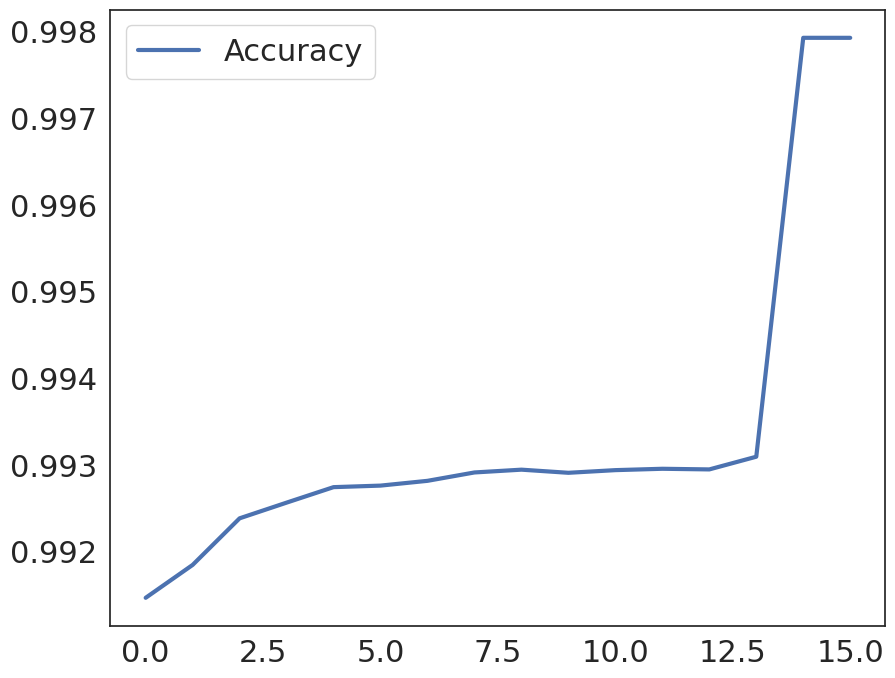

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_ae.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_ae(data_test_2018_corrected_r, X_test_r, y_test_r)

48021/48021 [==============================] - 59s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    768657
           1       1.00      1.00      1.00    768006

    accuracy                           1.00   1536663
   macro avg       1.00      1.00      1.00   1536663
weighted avg       1.00      1.00      1.00   1536663

48021/48021 - 61s - loss: 0.0021 - acc: 0.9979 - f1_m: 0.9978 - precision_m: 0.9999 - recall_m: 0.9959 - 61s/epoch - 1ms/step


### Hyper-parameter tuning Deep Neural Network

In [ ]:
def data():
  data2017_original = pd.read_parquet('/content/onedrive/data_2017_original.parquet', engine="fastparquet")

  X_train, X_test, y_train, y_test = split_data(data2017_original)

  data_test_2017_original = pd.concat([X_test, y_test], axis=1)

  X_train, X_test = normalise_data(X_train, X_test)
  return X_train, y_train, X_test, y_test

In [ ]:
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def model(X_train, Y_train, X_test, Y_test):
    '''
    Model providing function:
    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    '''
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, input_dim=76))
    model.add(tf.keras.layers.Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(tf.keras.layers.Dense(8))
    model.add(tf.keras.layers.Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(tf.keras.layers.Dense(1))
    model.add(tf.keras.layers.Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer={{choice(['rmsprop', 'adam', 'sgd'])}},
              metrics=['accuracy', f1_m, precision_m, recall_m])

    checkpoint_path = "/content/onedrive/models/dnn_classifier.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)
    start_time = time.time()

    model.fit(X_train, y_train,
              batch_size={{choice([32, 64, 128])}},
              epochs=1,
              verbose=1,
              validation_split=0.1,
              callbacks=cp_callback)

    end_time = time.time()
    time_taken = end_time - start_time
    print("Time taken to fit the model:", time_taken, "seconds")

    score, acc, f1, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test accuracy: {acc}, f1: {f1}, precision: {precision}, recall: {recall}')
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run, best_model = optim.minimize(model = model,
                                      data = data,
                                      max_evals = 10,
                                      algo = tpe.suggest,
                                      notebook_name = "gdrive/MyDrive/diss/train_deep_learning_methods",
                                      trials = Trials(),
                                      functions = [f1_m,precision_m, recall_m, split_data, normalise_data])

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    from google.colab import drive
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
except:
    pass

try:
    from sklearn.impute import SimpleImputer
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn.manifold import TSNE
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, precision_recall_curve
except:
    pass

try:
    from sklearn.metrics import recall_score, classification_report, auc, roc_curve
except:
    pass

try:
    from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
   

Cause: Unable to locate the source code of <function f1_m at 0x7a4349095bd0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function f1_m at 0x7a4349095bd0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
  0%|          | 0/10 [00:05<?, ?trial/s, best loss=?]

Cause: Unable to locate the source code of <function precision_m at 0x7a4349095a20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function precision_m at 0x7a4349095a20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
  0%|          | 0/10 [00:05<?, ?trial/s, best loss=?]

Cause: Unable to locate the source code of <function recall_m at 0x7a4349095ab0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Streaming output truncated to the last 5000 lines.
56711/56718 [============================>.] - ETA: 0s - loss: 0.0805 - accuracy: 0.9701 - f1_m: 0.8954 - precision_m: 0.9278 - recall_m: 0.8847

Epoch 1: saving model to /content/onedrive/models/dnn_classifier.ckpt

56718/56718 [==============================] - 304s 5ms/step - loss: 0.0805 - accuracy: 0.9701 - f1_m: 0.8954 - precision_m: 0.9278 - recall_m: 0.8847 - val_loss: 0.0593 - val_accuracy: 0.9791 - val_f1_m: 0.9272 - val_precision_m: 0.9551 - val_recall_m: 0.9145

Time taken to fit the model:
324.48058795928955
seconds
Test accuracy: 0.9795600771903992, f1: 0.9282286167144775, precision: 0.9546394944190979, recall: 0.9165390133857727
100%|██████████| 10/10 [33:23<00:00, 200.32s/trial, best loss: -0.9795600771903992]


In [ ]:
best_run

{'Activation': 1, 'Activation_1': 1, 'batch_size': 0, 'optimizer': 1}

### Train model by Deep Neural Network

In [ ]:
# define the model architecture
input_dim = X_train.shape[1] #num of feature columns

# Initialize the constructor, for dense layers added
dnn = tf.keras.Sequential()

# dnn.add(tf.keras.layers.Flatten()) #flattens the input data

# Add an input layer
dnn.add(tf.keras.layers.Dense(32, activation='sigmoid', input_dim=input_dim))

# Add one hidden layer
dnn.add(tf.keras.layers.Dense(8, activation='sigmoid'))

# Add an output layer
dnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
def train_dnn(X, y):
  dnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',f1_m,precision_m, recall_m])


  checkpoint_path = "/content/onedrive/models/dnn_classifier_resampling.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                   save_weights_only=True,
                                                   verbose=1)
  start_time = time.time()
  history_dnn = dnn.fit(X, y,
                      epochs=epochs,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.1,
                      verbose=1)
                      # callbacks=cp_callback)

  end_time = time.time()
  time_taken = end_time - start_time
  print("Time taken to fit the model:", time_taken, "seconds")
  return history_dnn

In [ ]:
def evaluate_dnn(df, X, y):
  ypred = dnn.predict(X)
  # Define a threshold for converting predictions to binary class labels
  threshold = 0.5

  # Convert predictions to binary class labels
  predicted_classes = (ypred >= threshold).astype(int)
  df['ypreds_dnn'] = predicted_classes
  print(classification_report(y, predicted_classes))
  dnn.evaluate(X, y, verbose=2)

### 2017 original

In [ ]:
history_dnn = train_dnn(X_train, y_train)

Epoch 1/16
56694/56718 [============================>.] - ETA: 0s - loss: 0.0860 - acc: 0.9694 - f1_m: 0.8933 - precision_m: 0.9258 - recall_m: 0.8834
Epoch 1: saving model to /content/onedrive/models/dnn_classifier.ckpt
56718/56718 [==============================] - 119s 2ms/step - loss: 0.0860 - acc: 0.9694 - f1_m: 0.8933 - precision_m: 0.9258 - recall_m: 0.8834 - val_loss: 0.0699 - val_acc: 0.9775 - val_f1_m: 0.9227 - val_precision_m: 0.9300 - val_recall_m: 0.9304
Epoch 2/16
56711/56718 [============================>.] - ETA: 0s - loss: 0.0617 - acc: 0.9784 - f1_m: 0.9241 - precision_m: 0.9543 - recall_m: 0.9100
Epoch 2: saving model to /content/onedrive/models/dnn_classifier.ckpt
56718/56718 [==============================] - 112s 2ms/step - loss: 0.0617 - acc: 0.9784 - f1_m: 0.9241 - precision_m: 0.9543 - recall_m: 0.9100 - val_loss: 0.0570 - val_acc: 0.9792 - val_f1_m: 0.9263 - val_precision_m: 0.9561 - val_recall_m: 0.9121
Epoch 3/16
56709/56718 [============================>.] 

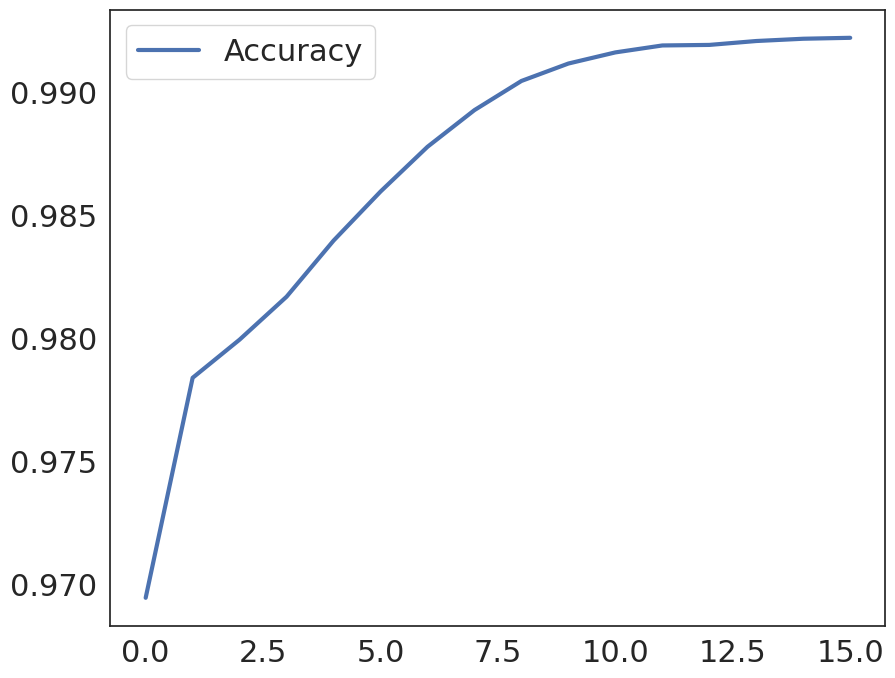

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_dnn.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_dnn(data_test_2017_original, X_test, y_test)

15755/15755 [==============================] - 29s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    418898
           1       0.99      0.96      0.98     85262

    accuracy                           0.99    504160
   macro avg       0.99      0.98      0.99    504160
weighted avg       0.99      0.99      0.99    504160

15755/15755 - 23s - loss: 0.0332 - acc: 0.9921 - f1_m: 0.9709 - precision_m: 0.9873 - recall_m: 0.9604 - 23s/epoch - 1ms/step


In [ ]:
data_test_2017_original

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label_encoded,ypreds_ae,ypreds_dnn
1435999,48,3,0,43,0,31,6,14.333333,14.433757,0,...,0.0000,0,0,0.000000e+00,0.00000,0,0,0,0,0
2435282,341545,2,1,6,0,6,0,3.000000,4.242641,0,...,0.0000,0,0,0.000000e+00,0.00000,0,0,0,0,0
854964,29130,3,1,38,6,38,0,12.666667,21.939310,6,...,0.0000,0,0,0.000000e+00,0.00000,0,0,0,0,0
2035034,100089920,5,8,382,11595,370,0,76.400000,164.154805,4344,...,0.0000,10982,10982,1.000000e+08,0.00000,100000000,100000000,1,1,1
1292198,51,2,2,4,12,2,2,2.000000,0.000000,6,...,0.0000,0,0,0.000000e+00,0.00000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435694,17,12,0,444,0,37,37,37.000000,0.000000,0,...,0.0000,0,0,0.000000e+00,0.00000,0,0,0,0,0
1990963,57620,3,0,0,0,0,0,0.000000,0.000000,0,...,0.0000,0,0,0.000000e+00,0.00000,0,0,0,0,0
1236925,116759175,18,15,962,1598,436,0,53.444444,139.182158,796,...,217888.8501,757206,34432,9.995332e+06,16522.30755,10000000,9945528,0,0,0
584801,261,2,0,12,0,6,6,6.000000,0.000000,0,...,0.0000,0,0,0.000000e+00,0.00000,0,0,0,0,0


In [ ]:
data_test_2017_original.to_parquet('/content/onedrive/test_result/data_test_dl_2017_original.parquet', index = False, compression=None, engine='fastparquet')

### Resampling

In [ ]:
history_dnn = train_dnn(X_train_r, y_train_r)

Epoch 1/16
19156/19159 [============================>.] - ETA: 0s - loss: 0.1415 - acc: 0.9488 - f1_m: 0.9454 - precision_m: 0.9395 - recall_m: 0.9562
Epoch 1: saving model to /content/onedrive/models/dnn_classifier_resampling.ckpt
19159/19159 [==============================] - 73s 4ms/step - loss: 0.1415 - acc: 0.9488 - f1_m: 0.9454 - precision_m: 0.9395 - recall_m: 0.9562 - val_loss: 0.0949 - val_acc: 0.9658 - val_f1_m: 0.9652 - val_precision_m: 0.9508 - val_recall_m: 0.9821
Epoch 2/16
19153/19159 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9677 - f1_m: 0.9670 - precision_m: 0.9587 - recall_m: 0.9779
Epoch 2: saving model to /content/onedrive/models/dnn_classifier_resampling.ckpt
19159/19159 [==============================] - 84s 4ms/step - loss: 0.0848 - acc: 0.9677 - f1_m: 0.9670 - precision_m: 0.9587 - recall_m: 0.9778 - val_loss: 0.0742 - val_acc: 0.9712 - val_f1_m: 0.9706 - val_precision_m: 0.9600 - val_recall_m: 0.9833
Epoch 3/16
19157/19159 [============

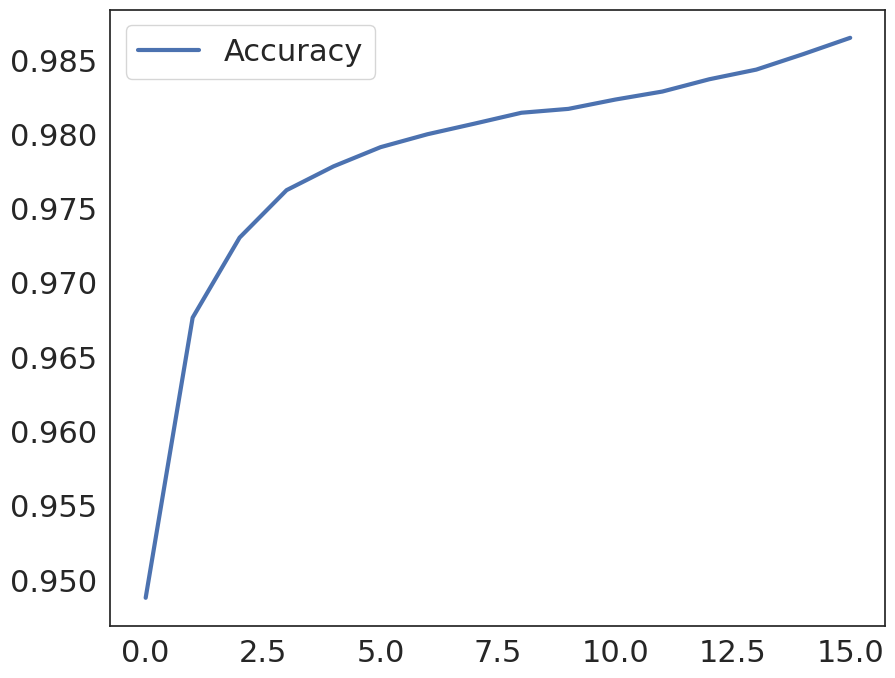

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_dnn.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_dnn(data_test_2017_original_r, X_test_r, y_test_r)

5322/5322 [==============================] - 10s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     85136
           1       0.98      0.99      0.98     85161

    accuracy                           0.98    170297
   macro avg       0.98      0.98      0.98    170297
weighted avg       0.98      0.98      0.98    170297

5322/5322 - 11s - loss: 0.0380 - acc: 0.9841 - f1_m: 0.9836 - precision_m: 0.9805 - recall_m: 0.9878 - 11s/epoch - 2ms/step


In [ ]:
data_test_2017_original_r.to_parquet('/content/onedrive/test_result/data_test_dl_2017_original_resample.parquet', index = False, compression=None, engine='fastparquet')

In [ ]:
data_test_2017_original_r

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label_encoded,ypreds_ae,ypreds_dnn
519642,458433,3,5,26,11607,20,0,8.666667,10.263203,7215,...,0.0,0,0,0.0,0.0,0,0,1,1,1
528801,97847168,8,7,56,11607,20,0,7.000000,5.656854,4380,...,0.0,2085934,2085934,94200000.0,0.0,94200000,94200000,1,1,1
288154,198,2,2,70,166,35,35,35.000000,0.000000,83,...,0.0,0,0,0.0,0.0,0,0,0,0,0
435861,315826,3,5,26,11607,20,0,8.666667,10.263203,10135,...,0.0,0,0,0.0,0.0,0,0,1,1,1
728431,115977201,8,6,319,11595,319,0,39.875000,112.783532,5792,...,0.0,4,4,57900000.0,59200000.0,99800000,16000000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179339,34758892,17,14,5300,2174,1755,0,311.764706,554.218654,348,...,0.0,0,0,0.0,0.0,0,0,0,0,0
368895,51174,2,2,84,228,42,42,42.000000,0.000000,114,...,0.0,0,0,0.0,0.0,0,0,0,0,0
193096,69,2,2,4,12,2,2,2.000000,0.000000,6,...,0.0,0,0,0.0,0.0,0,0,0,1,1
798446,100968822,8,7,311,11595,305,0,38.875000,107.551234,4344,...,0.0,1992,1992,101000000.0,0.0,101000000,101000000,1,1,1


### Train for 2017 improved dataset

In [ ]:
history_dnn = train_dnn(X_train, y_train)

Epoch 1/16
47250/47250 [==============================] - 120s 3ms/step - loss: 0.0188 - acc: 0.9957 - f1_m: 0.9915 - precision_m: 0.9937 - recall_m: 0.9912 - val_loss: 0.0030 - val_acc: 0.9994 - val_f1_m: 0.9988 - val_precision_m: 0.9992 - val_recall_m: 0.9985
Epoch 2/16
47250/47250 [==============================] - 117s 2ms/step - loss: 0.0028 - acc: 0.9994 - f1_m: 0.9986 - precision_m: 0.9992 - recall_m: 0.9982 - val_loss: 0.0026 - val_acc: 0.9994 - val_f1_m: 0.9987 - val_precision_m: 0.9995 - val_recall_m: 0.9981
Epoch 3/16
47250/47250 [==============================] - 117s 2ms/step - loss: 0.0021 - acc: 0.9995 - f1_m: 0.9987 - precision_m: 0.9992 - recall_m: 0.9984 - val_loss: 0.0019 - val_acc: 0.9996 - val_f1_m: 0.9991 - val_precision_m: 0.9996 - val_recall_m: 0.9988
Epoch 4/16
47250/47250 [==============================] - 115s 2ms/step - loss: 0.0019 - acc: 0.9996 - f1_m: 0.9989 - precision_m: 0.9994 - recall_m: 0.9985 - val_loss: 0.0021 - val_acc: 0.9996 - val_f1_m: 0.9991 -

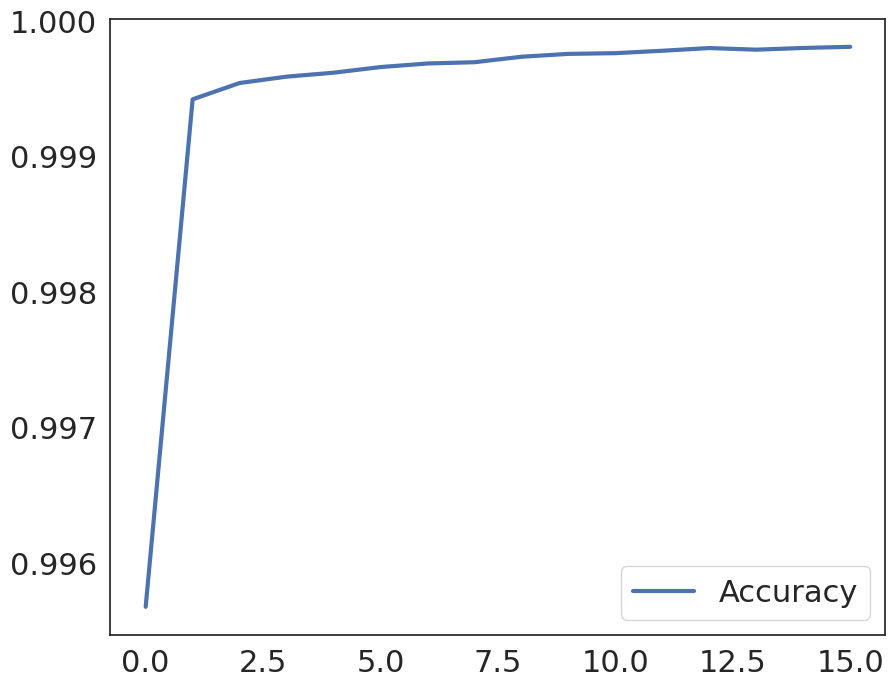

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_dnn.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_dnn(data_test_2017_corrected, X_test, y_test)

13125/13125 [==============================] - 18s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    319169
           1       1.00      1.00      1.00    100826

    accuracy                           1.00    419995
   macro avg       1.00      1.00      1.00    419995
weighted avg       1.00      1.00      1.00    419995

13125/13125 - 17s - loss: 9.0112e-04 - acc: 0.9998 - f1_m: 0.9994 - precision_m: 0.9994 - recall_m: 0.9994 - 17s/epoch - 1ms/step


In [ ]:
data_test_2017_corrected.to_parquet('/content/onedrive/test_result/data_test_dl_2017_corrected.parquet', index = False, compression=None, engine='fastparquet')

In [ ]:
del data_test_2017_corrected, X_test, y_test

In [ ]:
pd.read_parquet('/content/onedrive/test_result/data_test_dl_2017_corrected.parquet')

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Attempted Category,label_encoded,ypreds_ae,ypreds_dnn
0,928849,15,20,686,29585,347,0,45.733333,120.699430,4380,...,0.0,0,0,-1,-1,928849,-1,0,0,0
1,23956,1,1,46,62,46,46,46.000000,0.000000,62,...,0.0,0,0,-1,-1,0,-1,0,0,0
2,162,2,2,64,188,32,32,32.000000,0.000000,94,...,0.0,0,0,-1,-1,0,-1,0,0,0
3,19,13,0,195,0,15,15,15.000000,0.000000,0,...,0.0,0,0,-1,-1,0,-1,0,0,0
4,181,2,2,46,46,23,23,23.000000,0.000000,23,...,0.0,0,0,-1,-1,0,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419990,3,2,0,124,0,62,62,62.000000,0.000000,0,...,0.0,0,0,-1,-1,0,-1,0,0,0
419991,50,1,1,0,0,0,0,0.000000,0.000000,0,...,0.0,0,0,-1,-1,50,-1,1,1,1
419992,5806224,4,2,0,0,0,0,0.000000,0.000000,0,...,0.0,5732314,5732314,-1,-1,5806224,-1,0,0,0
419993,182,2,2,80,112,40,40,40.000000,0.000000,56,...,0.0,0,0,-1,-1,0,-1,0,0,0


### Resampling

In [ ]:
history_dnn = train_dnn(X_train_r, y_train_r)

Epoch 1/16
22745/22745 [==============================] - 53s 2ms/step - loss: 0.0456 - acc: 0.9907 - f1_m: 0.9893 - precision_m: 0.9929 - recall_m: 0.9868 - val_loss: 0.0123 - val_acc: 0.9977 - val_f1_m: 0.9976 - val_precision_m: 0.9985 - val_recall_m: 0.9969
Epoch 2/16
22745/22745 [==============================] - 55s 2ms/step - loss: 0.0078 - acc: 0.9986 - f1_m: 0.9986 - precision_m: 0.9990 - recall_m: 0.9982 - val_loss: 0.0046 - val_acc: 0.9991 - val_f1_m: 0.9990 - val_precision_m: 0.9992 - val_recall_m: 0.9988
Epoch 3/16
22745/22745 [==============================] - 51s 2ms/step - loss: 0.0042 - acc: 0.9992 - f1_m: 0.9991 - precision_m: 0.9995 - recall_m: 0.9989 - val_loss: 0.0025 - val_acc: 0.9995 - val_f1_m: 0.9995 - val_precision_m: 0.9997 - val_recall_m: 0.9993
Epoch 4/16
22745/22745 [==============================] - 52s 2ms/step - loss: 0.0030 - acc: 0.9994 - f1_m: 0.9994 - precision_m: 0.9996 - recall_m: 0.9992 - val_loss: 0.0042 - val_acc: 0.9988 - val_f1_m: 0.9988 - val

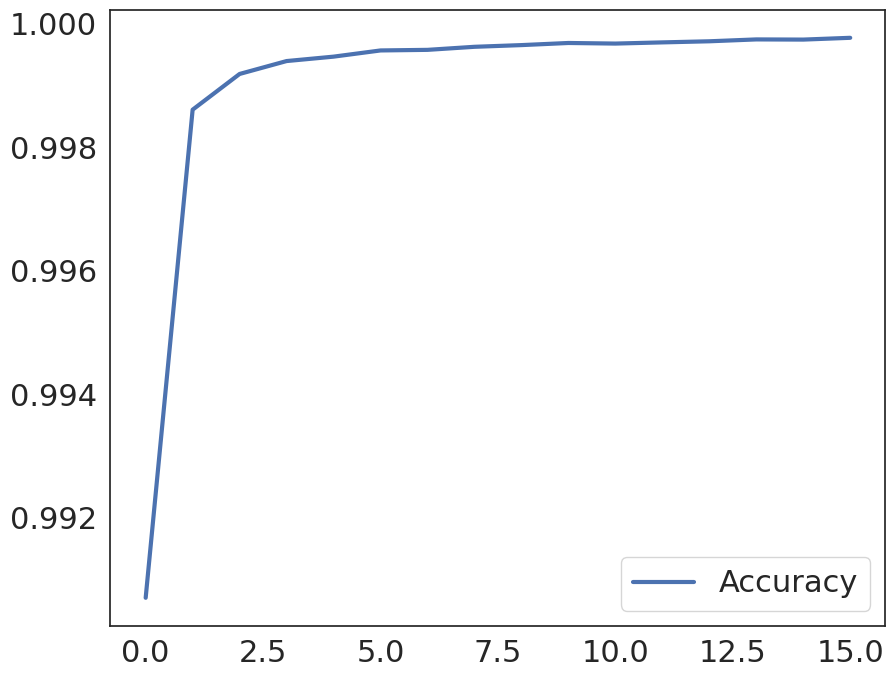

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_dnn.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_dnn(data_test_2017_corrected_r, X_test_r, y_test_r)

6318/6318 [==============================] - 8s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101297
           1       1.00      1.00      1.00    100876

    accuracy                           1.00    202173
   macro avg       1.00      1.00      1.00    202173
weighted avg       1.00      1.00      1.00    202173

6318/6318 - 9s - loss: 0.0019 - acc: 0.9996 - f1_m: 0.9996 - precision_m: 0.9995 - recall_m: 0.9998 - 9s/epoch - 1ms/step


In [ ]:
data_test_2017_corrected_r.to_parquet('/content/onedrive/test_result/data_test_dl_2017_corrected_resample.parquet', index = False, compression=None, engine='fastparquet')

### Train for 2018 original dataset

In [ ]:
history_dnn = train_dnn(X_train, y_train)

Epoch 1/16
243429/243429 [==============================] - 492s 2ms/step - loss: 0.0703 - acc: 0.9836 - f1_m: 0.9005 - precision_m: 0.9530 - recall_m: 0.8709 - val_loss: 0.0624 - val_acc: 0.9863 - val_f1_m: 0.9138 - val_precision_m: 0.9696 - val_recall_m: 0.8790
Epoch 2/16
243429/243429 [==============================] - 488s 2ms/step - loss: 0.0617 - acc: 0.9869 - f1_m: 0.9185 - precision_m: 0.9663 - recall_m: 0.8897 - val_loss: 0.0596 - val_acc: 0.9875 - val_f1_m: 0.9205 - val_precision_m: 0.9686 - val_recall_m: 0.8907
Epoch 3/16
243429/243429 [==============================] - 488s 2ms/step - loss: 0.0601 - acc: 0.9874 - f1_m: 0.9211 - precision_m: 0.9673 - recall_m: 0.8930 - val_loss: 0.0586 - val_acc: 0.9878 - val_f1_m: 0.9226 - val_precision_m: 0.9659 - val_recall_m: 0.8968
Epoch 4/16
243429/243429 [==============================] - 485s 2ms/step - loss: 0.0594 - acc: 0.9875 - f1_m: 0.9217 - precision_m: 0.9673 - recall_m: 0.8940 - val_loss: 0.0563 - val_acc: 0.9875 - val_f1_m: 

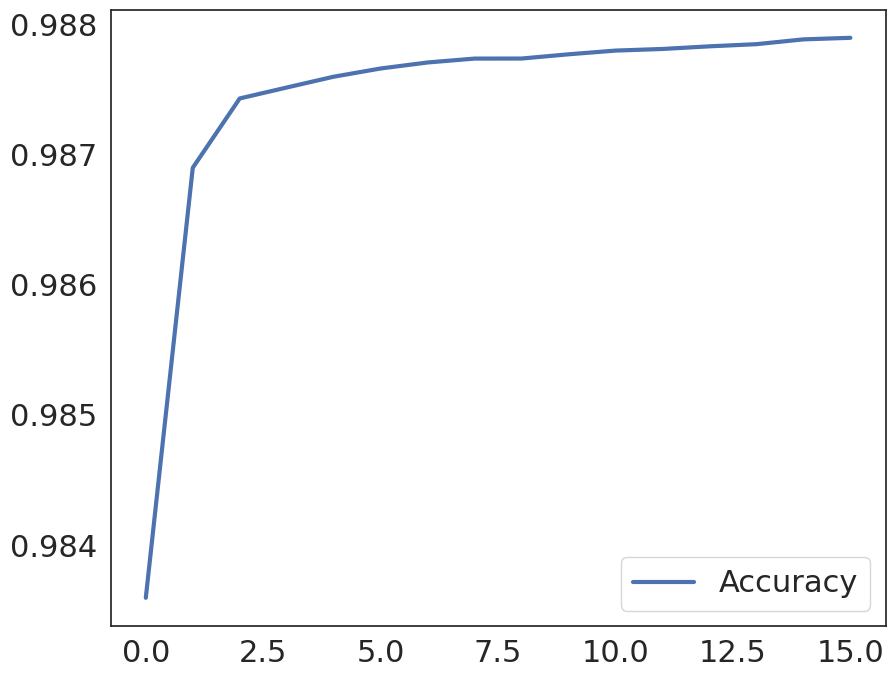

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_dnn.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_dnn(data_test_2018_original, X_test, y_test)

67620/67620 [==============================] - 76s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1898422
           1       0.99      0.91      0.95    265387

    accuracy                           0.99   2163809
   macro avg       0.99      0.95      0.97   2163809
weighted avg       0.99      0.99      0.99   2163809

67620/67620 - 78s - loss: 0.0535 - acc: 0.9880 - f1_m: 0.9232 - precision_m: 0.9702 - recall_m: 0.8938 - 78s/epoch - 1ms/step


In [ ]:
data_test_2018_original.to_parquet('/content/onedrive/test_result/data_test_dl_2018_original.parquet', index = False, compression=None, engine='fastparquet')

In [ ]:
del data_test_2018_original, X_test, y_test

In [ ]:
pd.read_parquet('/content/onedrive/test_result/data_test_dl_2018_original.parquet')

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label_encoded,ypreds_ae,ypreds_dnn
0,2026059.0,8.0,7.0,1032.0,1429.0,565.0,0.0,129.000000,190.919579,1149.0,...,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,0,0
1,53881189.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,0,0
2,1588367.0,3.0,4.0,20.0,964.0,20.0,0.0,6.666667,11.547005,964.0,...,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,1,1,1
3,12269.0,1.0,1.0,48.0,109.0,48.0,48.0,48.000000,0.000000,109.0,...,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,0,0
4,5415857.0,5.0,3.0,935.0,413.0,935.0,0.0,187.000000,418.144712,413.0,...,0.000000,0.0,0.0,5.347853e+06,0.000000,5347853.0,5347853.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163804,3214435.0,8.0,9.0,1148.0,1618.0,677.0,0.0,143.500000,228.129662,1173.0,...,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,0,0
2163805,20.0,2.0,0.0,53.0,0.0,53.0,0.0,26.500000,37.476659,0.0,...,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,0,0
2163806,2755980.0,11.0,9.0,1148.0,2813.0,677.0,0.0,104.363636,202.294475,1173.0,...,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,0,0
2163807,60933690.0,14.0,15.0,1555.0,4736.0,1228.0,0.0,111.071429,326.893882,1460.0,...,28012.960396,80237.0,11585.0,1.000346e+07,830.902321,10003836.0,10001763.0,0,0,0


### Resampling

In [ ]:
history_dnn = train_dnn(X_train_r, y_train_r)

Epoch 1/16
59663/59663 [==============================] - 111s 2ms/step - loss: 0.1562 - acc: 0.9494 - f1_m: 0.9460 - precision_m: 0.9835 - recall_m: 0.9146 - val_loss: 0.1406 - val_acc: 0.9541 - val_f1_m: 0.9507 - val_precision_m: 0.9910 - val_recall_m: 0.9166
Epoch 2/16
59663/59663 [==============================] - 111s 2ms/step - loss: 0.1378 - acc: 0.9538 - f1_m: 0.9505 - precision_m: 0.9902 - recall_m: 0.9168 - val_loss: 0.1385 - val_acc: 0.9532 - val_f1_m: 0.9495 - val_precision_m: 0.9940 - val_recall_m: 0.9119
Epoch 3/16
59663/59663 [==============================] - 113s 2ms/step - loss: 0.1350 - acc: 0.9544 - f1_m: 0.9512 - precision_m: 0.9908 - recall_m: 0.9174 - val_loss: 0.1350 - val_acc: 0.9543 - val_f1_m: 0.9508 - val_precision_m: 0.9930 - val_recall_m: 0.9149
Epoch 4/16
59663/59663 [==============================] - 116s 2ms/step - loss: 0.1331 - acc: 0.9548 - f1_m: 0.9515 - precision_m: 0.9914 - recall_m: 0.9176 - val_loss: 0.1335 - val_acc: 0.9540 - val_f1_m: 0.9504 -

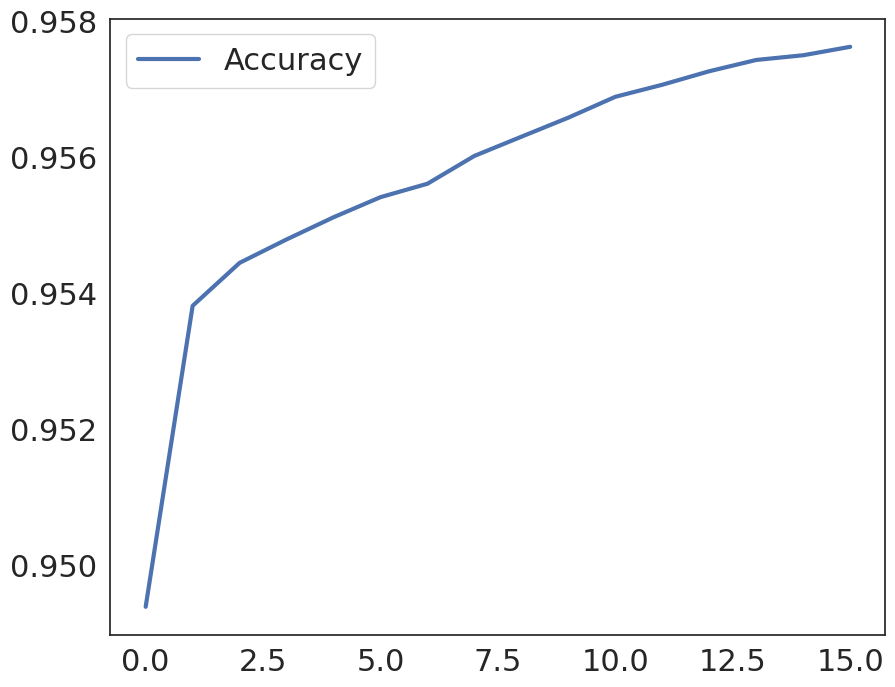

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_dnn.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_dnn(data_test_2018_original_r, X_test_r, y_test_r)

16574/16574 [==============================] - 19s 1ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    265099
           1       0.99      0.92      0.96    265239

    accuracy                           0.96    530338
   macro avg       0.96      0.96      0.96    530338
weighted avg       0.96      0.96      0.96    530338

16574/16574 - 20s - loss: 0.1247 - acc: 0.9577 - f1_m: 0.9546 - precision_m: 0.9946 - recall_m: 0.9204 - 20s/epoch - 1ms/step


In [ ]:
data_test_2018_original_r.to_parquet('/content/onedrive/test_result/data_test_dl_2018_original_resample.parquet', index = False, compression=None, engine='fastparquet')

In [ ]:
pd.read_parquet('/content/onedrive/test_result/data_test_dl_2018_original_resample.parquet')

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label_encoded,ypreds_ae,ypreds_dnn
0,11873479.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,11900000.0,0.0,11900000.0,11900000.0,1,1,1
1,29878.0,3.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2,4310567.0,5.0,3.0,935.0,333.0,935.0,0.0,187.000000,418.144712,333.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,40660004.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,40700000.0,0.0,40700000.0,40700000.0,1,1,1
4,1182753.0,3.0,4.0,20.0,964.0,20.0,0.0,6.666667,11.547005,964.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530333,391032.0,22.0,20.0,1928.0,2665.0,640.0,0.0,87.636364,137.780552,976.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
530334,6315178.0,4.0,4.0,97.0,232.0,97.0,0.0,24.250000,48.500000,232.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
530335,9451.0,3.0,4.0,316.0,935.0,316.0,0.0,105.333333,182.442685,935.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
530336,249.0,3.0,1.0,289.0,0.0,258.0,0.0,96.333333,140.862817,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [ ]:
del data_test_2018_original_r

### 2018 improved

In [ ]:
history_dnn = train_dnn(X_train, y_train)

Epoch 1/16
219983/219983 [==============================] - 450s 2ms/step - loss: 0.0059 - acc: 0.9984 - f1_m: 0.9980 - precision_m: 0.9986 - recall_m: 0.9975 - val_loss: 0.0024 - val_acc: 0.9992 - val_f1_m: 0.9989 - val_precision_m: 0.9991 - val_recall_m: 0.9988
Epoch 2/16
219983/219983 [==============================] - 446s 2ms/step - loss: 0.0021 - acc: 0.9993 - f1_m: 0.9991 - precision_m: 0.9995 - recall_m: 0.9988 - val_loss: 0.0021 - val_acc: 0.9994 - val_f1_m: 0.9992 - val_precision_m: 0.9998 - val_recall_m: 0.9988
Epoch 3/16
219983/219983 [==============================] - 517s 2ms/step - loss: 0.0018 - acc: 0.9994 - f1_m: 0.9992 - precision_m: 0.9995 - recall_m: 0.9990 - val_loss: 0.0018 - val_acc: 0.9995 - val_f1_m: 0.9993 - val_precision_m: 0.9998 - val_recall_m: 0.9989
Epoch 4/16
219983/219983 [==============================] - 748s 3ms/step - loss: 0.0017 - acc: 0.9994 - f1_m: 0.9993 - precision_m: 0.9996 - recall_m: 0.9990 - val_loss: 0.0019 - val_acc: 0.9995 - val_f1_m: 

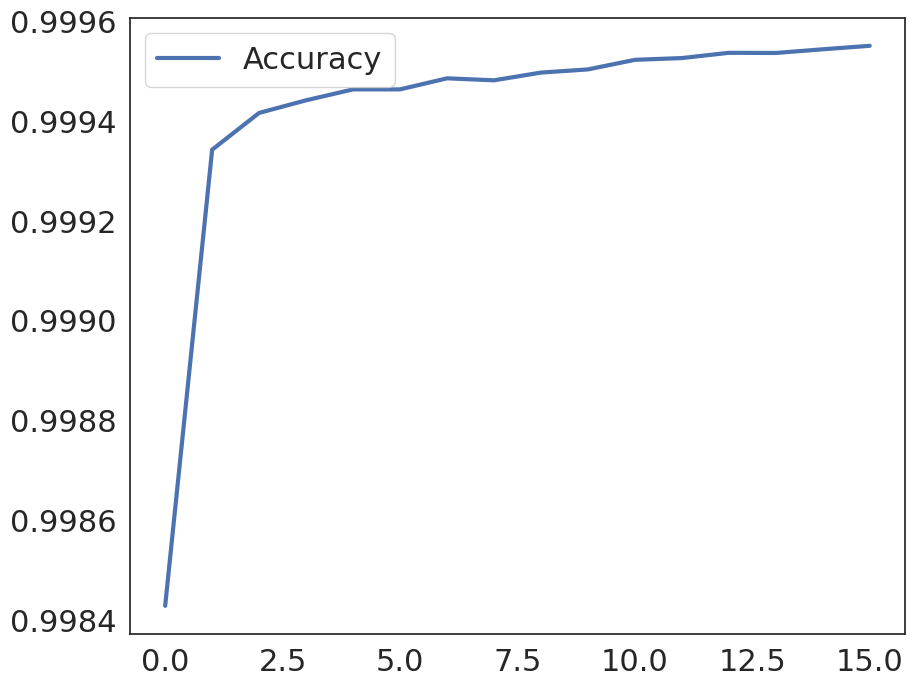

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_dnn.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_dnn(data_test_2018_corrected, X_test, y_test)

61107/61107 [==============================] - 68s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1186654
           1       1.00      1.00      1.00    768746

    accuracy                           1.00   1955400
   macro avg       1.00      1.00      1.00   1955400
weighted avg       1.00      1.00      1.00   1955400

61107/61107 - 72s - loss: 0.0014 - acc: 0.9995 - f1_m: 0.9994 - precision_m: 0.9999 - recall_m: 0.9989 - 72s/epoch - 1ms/step


In [ ]:
data_test_2018_corrected.to_parquet('/content/onedrive/test_result/data_test_dl_2018_corrected.parquet', index = False, compression=None, engine='fastparquet')

In [ ]:
pd.read_parquet('/content/onedrive/test_result/data_test_dl_2018_corrected.parquet')

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,label_encoded,ypreds_ae,ypreds_dnn
0,37774763,5,4,20,964,20,0,4.000000,8.944272,964,...,36555117.0,0.0,36555117,36555117,-1,-1,37774763,1,1,1
1,129817,5,5,352,935,352,0,70.400000,157.419186,935,...,0.0,0.0,0,0,-1,-1,129817,1,1,1
2,163806,5,5,293,935,293,0,58.600000,131.033583,935,...,0.0,0.0,0,0,-1,-1,163806,1,1,1
3,130579,5,5,353,935,353,0,70.600000,157.866399,935,...,0.0,0.0,0,0,-1,-1,130579,1,1,1
4,90344801,13,10,1341,1579,629,0,103.153846,171.701216,1155,...,86333021.0,0.0,86333021,86333021,-1,-1,90344801,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955395,1140088,6,5,455,338,140,0,75.833333,62.936211,145,...,0.0,0.0,0,0,-1,-1,1140088,0,0,0
1955396,11862,1,1,50,137,50,50,50.000000,0.000000,137,...,0.0,0.0,0,0,-1,-1,0,0,0,0
1955397,3002,5,5,313,935,313,0,62.600000,139.977855,935,...,0.0,0.0,0,0,-1,-1,3002,1,1,1
1955398,1276,1,1,31,47,31,31,31.000000,0.000000,47,...,0.0,0.0,0,0,-1,-1,0,0,0,0


### resampling

In [ ]:
history_dnn = train_dnn(X_train_r, y_train_r)


Epoch 1/16
172875/172875 [==============================] - 354s 2ms/step - loss: 0.0077 - acc: 0.9979 - f1_m: 0.9976 - precision_m: 0.9981 - recall_m: 0.9973 - val_loss: 0.0028 - val_acc: 0.9992 - val_f1_m: 0.9991 - val_precision_m: 0.9990 - val_recall_m: 0.9993
Epoch 2/16
172875/172875 [==============================] - 351s 2ms/step - loss: 0.0024 - acc: 0.9992 - f1_m: 0.9992 - precision_m: 0.9994 - recall_m: 0.9990 - val_loss: 0.0023 - val_acc: 0.9993 - val_f1_m: 0.9992 - val_precision_m: 0.9991 - val_recall_m: 0.9994
Epoch 3/16
172875/172875 [==============================] - 357s 2ms/step - loss: 0.0020 - acc: 0.9993 - f1_m: 0.9993 - precision_m: 0.9995 - recall_m: 0.9992 - val_loss: 0.0021 - val_acc: 0.9993 - val_f1_m: 0.9993 - val_precision_m: 0.9999 - val_recall_m: 0.9987
Epoch 4/16
172875/172875 [==============================] - 351s 2ms/step - loss: 0.0019 - acc: 0.9994 - f1_m: 0.9994 - precision_m: 0.9995 - recall_m: 0.9992 - val_loss: 0.0021 - val_acc: 0.9993 - val_f1_m: 

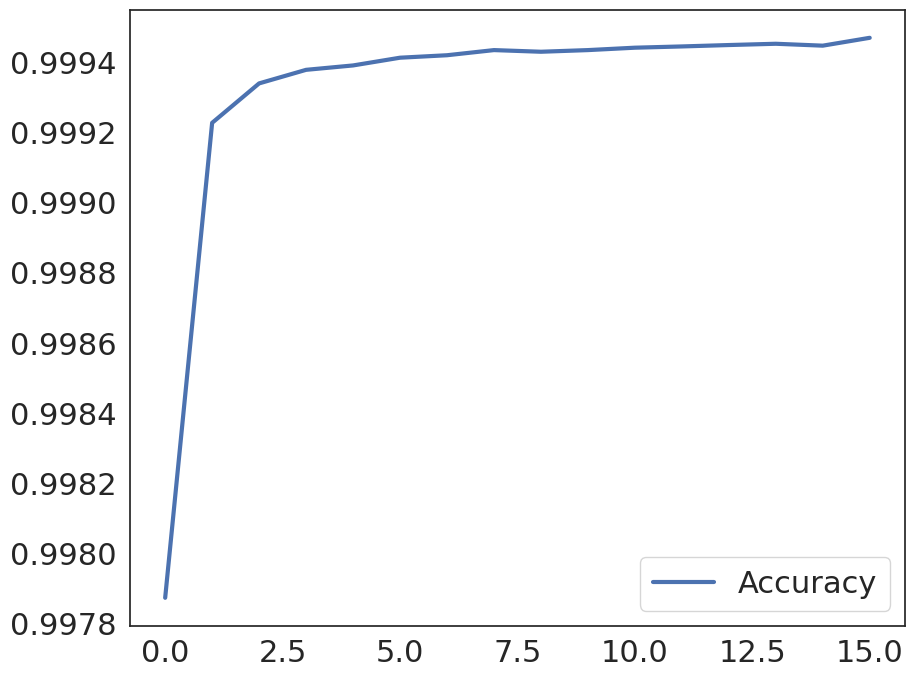

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
# plt.plot(history_ae.history["loss"], label="Training Loss",linewidth=3.0)
# plt.plot(history_ae.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.plot(history_dnn.history["acc"], label="Accuracy",linewidth=3.0)
plt.legend()

In [ ]:
evaluate_dnn(data_test_2018_corrected_r, X_test_r, y_test_r)

48021/48021 [==============================] - 54s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    768657
           1       1.00      1.00      1.00    768006

    accuracy                           1.00   1536663
   macro avg       1.00      1.00      1.00   1536663
weighted avg       1.00      1.00      1.00   1536663

48021/48021 - 57s - loss: 0.0016 - acc: 0.9994 - f1_m: 0.9994 - precision_m: 0.9991 - recall_m: 0.9997 - 57s/epoch - 1ms/step


In [ ]:
data_test_2018_corrected_r.to_parquet('/content/onedrive/test_result/data_test_dl_2018_corrected_resample.parquet', index = False, compression=None, engine='fastparquet')

In [ ]:
pd.read_parquet('/content/onedrive/test_result/data_test_dl_2018_corrected_resample.parquet')

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,label_encoded,ypreds_ae,ypreds_dnn
0,60012672,6,5,97,232,97,0,16.166667,39.600084,232,...,5.500727e+07,0.00000,55007268,55007268,-1,-1,60012672,0,0,0
1,1148,1,1,33,90,33,33,33.000000,0.000000,90,...,0.000000e+00,0.00000,0,0,-1,-1,0,0,0,0
2,115307882,22,21,723,5704,350,0,32.863636,86.633489,1460,...,1.000769e+07,18762.24329,10014805,9952906,-1,-1,115307882,0,0,0
3,48712,5,5,248,935,248,0,49.600000,110.908972,935,...,0.000000e+00,0.00000,0,0,-1,-1,48712,1,1,1
4,1151067,6,5,359,935,359,0,59.833333,146.561136,935,...,0.000000e+00,0.00000,0,0,-1,-1,1151067,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536658,1002694,2,0,0,0,0,0,0.000000,0.000000,0,...,0.000000e+00,0.00000,0,0,-1,-1,1002694,0,0,0
1536659,369282,25,23,1944,2665,640,0,77.760000,132.252687,976,...,0.000000e+00,0.00000,0,0,-1,-1,369282,1,1,1
1536660,30514,5,5,314,935,314,0,62.800000,140.425069,935,...,0.000000e+00,0.00000,0,0,-1,-1,30514,1,1,1
1536661,3408,1,1,33,70,33,33,33.000000,0.000000,70,...,0.000000e+00,0.00000,0,0,-1,-1,0,0,0,0


In [ ]:
del data_test_2018_corrected_r